# Code of the model and its outputs

Printing each and every cell was making the notebook too much verbose so rather i just printed the important info skipping much of them and instead i have commented the values of variables which you will get after printing them

## Step 1 : Loading the data set and modules

#### a. Loading the dataset




* We will use the unzip command to load the dataset from the zip file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Following will unzip the data provided so that we can work with it
!unzip '/content/drive/MyDrive/image_captions.zip' >/dev/null

#### b. Modules


I have included the following modules
1. **os** : to handle the files
2. **numpy** : Its kind of the basic requirement of every ml project as the neural networks processes and outputs the arrays which can be handled by the numpy.
3. **tqdm** : This feature i found on the internet which when added to for loop gives you a nice visulisation of how much process is done or through a horizontal bar
4. **vgg16, preprocess_input** : I have added this pretrained model to extract the image features and also added some methods required in it.
5. **load_img, img_to_array** : as the name suggests they do the work according to their name
6. **Tokenizer** : We included tokenizer to convert the caption strings to token which is easy to process by the neural networks and it has lot of other functionalities explained later
7. **pad_sequences** : this provides padding to the sequences of tokens of variable length so that we have sequence of same length
8. **Model** : obivously we need this to make our encoder and decoder model
9. **utils** : added **to_categorical** (which just provide hot encoding to the tokens of sequences) and **plot_model** (this is just to get sense of how the model is made)
10. **layers** : I have included some layers which i will explain in detail later

In [ ]:
### Modules
import os
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

## Step 2 : Extraction of image features






#### a. Creating the model for extraction of image features

* For extraction of image features we will use VGG16 model which is used for image classification
* As it is classifying image it has extracted all features of the image in some of its layer so we will use that layer output as our image features

In [ ]:
vgg16_model = VGG16() # Load the module
print(vgg16_model.summary()) # summarize the module

553467096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

* As we can see at last there is prediction layer in this model which take the image features as input and predict so the output of the second last layer would be the image features
* So we will modify the model such that the output of the new model is just the second last layer which is layer fc2
* We are also able to observe that it is giving output of size 4096 means we will get 4096 features of the image

In [ ]:
feature_model = Model(inputs = vgg16_model.inputs , outputs = vgg16_model.layers[-2].output) # restructure the model
print(feature_model.summary()) # summarize the modified model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### b. Extraction of image features

So to extract the image features we will follow the follow the following steps
1. Make a features dicitionary which will be of form key as image id and value as list of features of the particular image
2. load the images and loop over them (caution : image should be of size (224, 224) as vgg16 take input image as size of that)
3. convert the images into array as any ml model take input as numpy arrays and reshape them according to input of our vgg16 model
4. store the features in the dicitionary

* preprocess_input is method of vgg16 model which verifies if input is of required size if its not it make some changes even we are taking care of it still we are adding it to be in safe side

In [ ]:
### So now lets extract the featueres using the model we obtained above

features = {}
img_dir = '/content/Images'

for img_name in tqdm(os.listdir(img_dir)):
  img_path = img_dir + '/' + img_name
  image = load_img(img_path, target_size = (224,224))
  image = img_to_array(image) # convert the pixel into arrays
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # reshape the array to size (224,224,3)
  image = preprocess_input(image)
  feature = feature_model.predict(image, verbose = 0)
  img_id = img_name.split('.')[0]
  features[img_id] = feature # Storing the feature

# 8091 images are there in the file

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
import pickle

# store features in pickle
pickle.dump(features, open('/content/features.pkl', 'wb'))

In [ ]:
# load features from pickle
with open('/conent/features.pkl', 'rb') as f:
    features = pickle.load(f)

## Step 3 : Procesing the captions

#### a. Loading the captions


So the primary work of ours here would be to load the captions form captions.txt and then map it to its coressponding images

In [ ]:
with open('/content/captions.txt', 'r') as file_pointer:
  next(file_pointer) # Skips the first line
  cap_doc = file_pointer.read()

We will now create a dictionary which will map image_id s with their correspoding captions

In [ ]:
cap_map = {}

# Read from each line of the file and insert the captions into the mapping
for line in tqdm(cap_doc.split('\n')):
  if len(line) < 2: # this is just to remove some noise if there is
        continue
  tokens = line.split(',')
  img_id = tokens[0].split('.')[0]
  caption = tokens[1:]
  caption = " ".join(caption)
  if img_id not in cap_map:
    cap_map[img_id] = []
  cap_map[img_id].append(caption) # we created a list of captions for each image_id

# There are 40456 captions in txt file

  0%|          | 0/40456 [00:00<?, ?it/s]

#### b. Preprocess the captions

**Clean the caption** : here we will remove the unwanted elements from the captions so that it wont interfere with the fitting of the model and will make captions easier to process

* These are the following thing which will clean
1. Change all captions into lowercase
2. Remove all characters except alphabets
3. Replace multiple spaces with single space
4. Add start and end tag in the caption so that it can notify start and end of the caption

In [ ]:
def clean(cap_map):
  for key, captions in cap_map.items():
    for i in range(len(captions)):
      caption = captions[i]
      caption = caption.lower() # 1
      caption = caption.replace('[^A-Za-z]', '') # 2
      caption = caption.replace('\s+' , ' ') # 3
      caption = '<start> ' + caption + ' <end>' # 4
      captions[i] = caption

clean(cap_map)

#### c. Processing/Tokenizing the captions



*   So in processing the captions parts we will tokenize the text and will make a vocablury out of it so that the its would be easier for the model to interpret and learn from the captions and it will also get the words to generate the captions
* So we will follow the following steps



1. Fist we will create a single list of all captions so that we can fed it in tokenizer

In [ ]:
all_cap = []
for key in cap_map.keys():
  for caption in cap_map[key]:
    all_cap.append(caption)

2. Now we will tokenize the text using the inbuilt Tokenizer of keras which we will store in the dictionary named tokenizer.

In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cap)

3. We will also get some additional data like
  >1. vocab_size : Which tells about the number of words in our dictionary
  >2. max_length : Tells us about the maximum length of the caption present



In [ ]:
vocab_size = len(tokenizer.word_index) + 1 #tokenizer.word_index is a dictionary
# vocab_size = 8494
max_length = max(len(caption.split()) for caption in all_cap) # max length among all captions
# max_length = 37

## Step 4 : Data splitting and Data Generator

#### a. Data Splitting



*   We will split the data in train (80%), validate (10%), test (10%) sets



In [ ]:
img_id = list(cap_map.keys())
split1 = int((len(img_id)) * 0.8)
split2 = int((len(img_id))* 0.9)
train = img_id[:split1]   # 6472
test = img_id[split1:split2]  # 809
validate = img_id[split2:]  # 810

#### b. Data generator






* The function of the data generator is modify captions input , it would be inputted like for first word of the certain caption output would be second word, for sequence of first 2 words of the caption would be third word of the caption and so on.
* With the sequence of caption we will also give it a corresponding image's features
* So the model will have two inputs : list of sequence and corresponding image features
* One more use of data generator is to generate batch size data as if we give this much big data directly it will crash



In [ ]:
def data_generator(data_keys, cap_map, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0 # counter for batch size
    while 1:
        for key in data_keys:
            n += 1
            captions = cap_map[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0] # seq of index in vocablury
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]  # splitting input sequences as mentioned above
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence by providing it hot encoding
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                # This return the array with X1, X2 combined and y
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Step 5 : Creating and Training the model

#### a. Model Creation


So our model will contain two parts
1. Encoder Model
>This model will have two different path of layers both path will converge in the decoder model
>1. Image feature path (This path will contain layers which will work on image features)
>>1. inputs1 : This is an input layer which will take 4096 features of images as inputs.
>>2. ifp_l1 : This is a dropout layer with dropout rate = 0.4  which is useful for avoiding overfitting. As it drops some features randomly with the probability given to it so avoiding the overfitting.
>>3. ifp_l2 : This is dense layer with relu activation. This layer will help model in learning more complex as every neuron of previous layer is connected to every neuron of this layer
>2. Sequence path (This path will learn from the sequences)
>>1. inputs2 : This is an input layer which take sequences of length max_length as input.
>>2. sfp_l1 : This is an embedding layer which converts the integers in sequences(which we got from tokenizing the sequence) into dense vector form so it can be processed by next layer.
>>3. sfp_l2 : Its an dropout layer with dropout rate = 0.4 .
>>4. sfp_l3 : This is an LSTM layer which help in finding the long term dependencies in the sequence features

2. Decoder model
>1. decoder1 : Its an add layer which combines the output of both paths.
>2. decoder2 : Its a Dense layer with relu activation
>3. ouptut : finally this layer is a dense layer with softmax activation as we have to classify it in multiclass to give output as word

3. We then compiled the model with categorical_crossentropy as loss function and adam as optimizer.

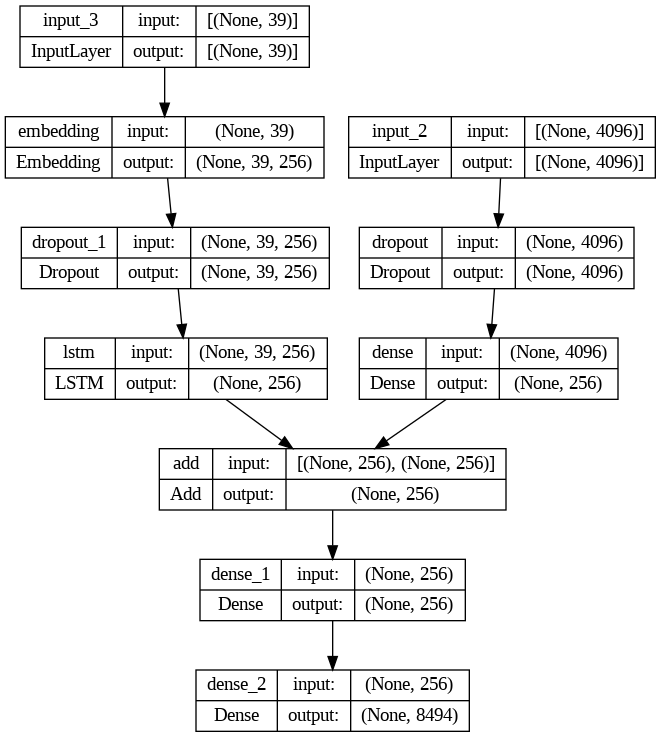

In [ ]:
### Encoder Model

## Image feature path
inputs1 = Input(shape=(4096,))
ifp_l1 = Dropout(0.4)(inputs1)
ifp_l2 = Dense(256, activation = 'relu')(ifp_l1)

## Sequence feature layer
inputs2 = Input(shape=(max_length,))
sfp_l1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
sfp_l2 = Dropout(0.4)(sfp_l1)
sfp_l3 = LSTM(256)(sfp_l2)

## decoder model
decoder1 = add([ifp_l2, sfp_l3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


#### b. Train model

So now we will train the model by creating the data generator instance and fitting the model on the data denerated by data generator

In [ ]:
# train the model
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
  generator = data_generator(train, cap_map, features, tokenizer, max_length, vocab_size, batch_size)
  model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1 )


202/202 [==============================] - 61s 303ms/step - loss: 2.2953


In [ ]:
# save the model
model.save('/content/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Optional load the trained model

In [ ]:
from tensorflow.keras.models import load_model

# Replace 'model.h5' with the path to your .h5 file
model = load_model('model.h5')

## Step 6: Caption predictor

First we will define a function which convert the index of tokens into words by searching for the word in dictionary .
We will need this function in our caption predictor

In [ ]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

Now we will make a caption predictor which will do the following steps
1. first will encode the sequences using tokenizer
2. Pad the sequence to make it proper input length
3. Predict the output using model
4. The output would be the array telling u the probability of each word being our next word we will chose the best of it.
5. convert the index into word and add the word in our prediction
6. We will stop adding word if no words are proper to be added or we reached the max limit

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
  in_text = 'startseq' # add start tag
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], max_length)
    yhat = model.predict([image, sequence], verbose = 0)
    yhat = np.argmax(yhat)
    word = idx_to_word(yhat, tokenizer)
    if word is None or word == 'end' or word == 'endseq':
        in_text += " " + 'endseq'
        break
    in_text += " " + word
  return in_text

## Step 7: Model Evaluation and Validation

* Now we will evalute our model and validate it on validation set and will make some changes if needed
* We are going to evaluate our model using BLEU matrix

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(validate):
    captions = cap_map[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

# adam -: 0.204256, 0.112802

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.115278
BLEU-2: 0.066229


## Step 8: Testing the results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_id):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_name = image_id + ".jpg"
    img_path = "/content/Images/" + image_name
    image = Image.open(img_path)
    captions = cap_map[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
<start> a man does a trick on his skateboard in front of a crowd . <end>
<start> a skateboarder without a shirt grabs his board in the air . <end>
<start> a young man shocks the audience with his skateboard tricks . <end>
<start> man with no shirt and tatoos on back airborne with skateboard in hand . <end>
<start> the skateboarder performs a jump in front of a crowd of spectators . <end>
--------------------Predicted--------------------
startseq marching lead a group of people are standing in front of a building endseq


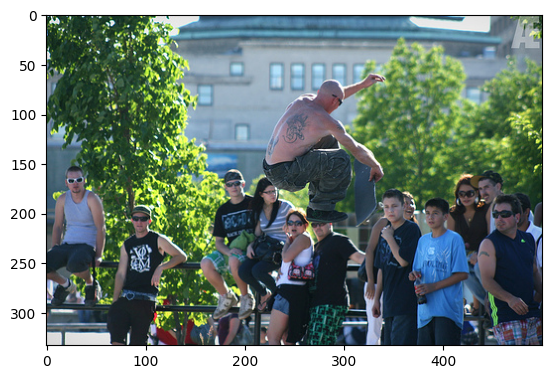

In [ ]:
import random

test_image_id = random.choice(test)
generate_caption(test_image_id)

# Summary Report and Reflections

## Summary of the model

* So The model is processing the image and the captions and predicting the next word which we can add in our caption
* The model works like it takes input as the image features generated from pretrained model (vgg16()) and the partial caption seperately learn from them then combine both of the and learn the combination of them and then predict the next word which we should add in our caption.
* In this model we have used layers like lstm to provide long term dependency to the model , dropout layer to reduce the overfitting of the data, embedding layer to convert the sequence to dense vector, etc.
* For detailed info u can refer to the code as i have explained everything there

## Trials

1. I tried a non prebuild model which was not working properly so after i used the vgg16 model.
2. I tried the caption extraction without cleaning it at first it was giving horrible results then i cleaned the caption before using it to train the model.
3. I tried to run the model on different number or epochs it was getting better as we increase the no. of epochs but after one point the growth was very less and it was taking much time so i took the middle one which is 10.

* Actually as i mentioned due to the limitation of resources i was not able to try much of the things.

## Challenges faced

1. Caption generation was completely new thing for me so i have to take the help of youtube references.
2. Find a pre built model for extraction of the image features
3. Making model such that it can learn image features and captions.
4. Understanding how the model works which i referenced from a youtube video.
5. Resizing input according to the model.
6. Finding what to do for overfitting.
7. Making choices for model as everytime running the model used to take nearly 1.5 hours and google colab resources was getting over by that time so to run the model have to wait for next day so wasnt able to try much patterns.



## Choices made

1. VGG16() -: I chose vgg16 model for extraction of image features as it was simple and first model which i found out when searched.
2. softmax -: I chose softmax activation at the end of the model as softmax activation is used for multiclass classification and our model was doing that.
3. categorical_crossentropy -: As our model is multiclass classifier thats why we have to use categorical_crossentropy as a loss function.
4. adam -: adam is widely used optimizer so i gone with it

## Further improvements

1. We can further improve this model first of all by having a google colab pro so we can test a lot of options lol.
2. Using a accurate image feature extraction model which are complex.
3. Insted of training data on 8091 we can train it on something big data.
4. Including many layers in our model.